In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('WindData_Model.csv')

In [3]:
# Independent and dependent features
X = df.iloc[:, 2:]
y = df.iloc[:, 1]
y.head()

0     380.047791
1     447.605713
2     710.587280
3     736.647827
4    1493.807983
Name: Power, dtype: float64

In [4]:
# Important features
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(X, y)
print(model.feature_importances_)

[0.75833161 0.24166839]


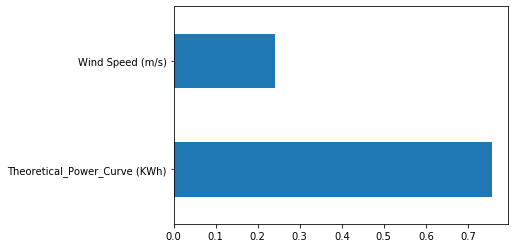

In [5]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

In [6]:
# Import the necessary packages
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
#import xgboost as xgb
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,mean_squared_log_error

In [7]:
# Train/test split method
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6737, 2), (1685, 2), (6737,), (1685,))

In [8]:
scaler =  StandardScaler()
# Standardize only continuous features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
print(X_train_scaled)

[[ 1.29934283  0.81504324]
 [-1.08698256 -1.2028258 ]
 [ 0.43484373  0.32371789]
 ...
 [-1.03001805 -0.90831934]
 [-1.08698256 -1.38717605]
 [ 1.27818304  0.79638139]]


In [9]:
# Cross validation method to choose the best train/test 
import math
lin_model = LinearRegression(normalize=False, n_jobs=-1)
lin_model.fit(X_train_scaled, y_train)


cv1 = cross_val_score(lin_model, X_train_scaled, y_train, cv=10)

print(cv1)

[0.93309182 0.9279131  0.9526562  0.85933633 0.88652981 0.89401401
 0.87349989 0.88162372 0.88881763 0.8973335 ]


In [10]:
cv2 = -cross_val_score(lin_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
reg_metric = round(math.sqrt(cv2.mean()),3)

In [11]:
# The new train/test dataframes
x1, x2 = df.iloc[0:4055,2:], df.iloc[5740:,2:]
X_train = pd.concat([x1, x2])
X_test = df.iloc[4055:5740,2:]

y1, y2 = df.iloc[0:4055,1], df.iloc[5740:,1]
y_train = pd.concat([y1, y2])

y_test = df.iloc[4055:5740,1]
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((6737, 2), (1685, 2), (6737,), (1685,))

In [12]:
# 1)SVR MODEL

svr_model = SVR()

pipe_svr = Pipeline([('standardizer', scaler), ('regressor', svr_model)])
param_grid_svr ={    'regressor__gamma' : [0.001, 0.01, 0.1],
                     'regressor__C' : [50,60,70] 
                }

grid_svr = GridSearchCV(pipe_svr, param_grid_svr, cv=5, error_score='raise')

grid_svr.fit(X_train,y_train)
preds_svr = grid_svr.predict(X_test)

In [13]:
# 2)Random Forest 
rf_model = RandomForestRegressor(random_state = 0, n_jobs=-1)
param_grid_rf = {'n_estimators': [100, 110, 130, 140]}
                 #'regressor__max_depth': [3, None],
                 #'regressor__max_features': [1, 3, 10],
                 #'regressor__min_samples_split': [2, 3, 10],
                 #'regressor__min_samples_leaf': [1, 3, 10],
                  #'regressor__bootstrap': [True, False]'''


grid_rf = GridSearchCV(estimator = rf_model, param_grid  = param_grid_rf,  cv=5, error_score='raise')

grid_rf.fit(X_train, y_train)
preds_rf1 = grid_rf.predict(X_test)


In [14]:
# 3)XGBoost 
#xgb_model = xgb.XGBRegressor(n_jobs = -1)
#param_grid_xgb = { 'max_depth':[4,5,6],
#                  'n_estimators': [100, 110, 130, 140],
#                   'learning_rate': [0.1, 0.5, 0.7]
#                    }

#grid_xgb = GridSearchCV(estimator = xgb_model, param_grid  = param_grid_xgb,  cv=5, error_score='raise')

#grid_xgb.fit(X_train, y_train)
#preds_xgb1 = grid_xgb.predict(X_test)

In [15]:
import numpy as np
# 4) RandomForestRegressor with Randomized Search
rf = RandomForestRegressor()


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

random_grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid_rf, scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose = 2, random_state = 42, n_jobs = 1)
rf_random.fit(X_train, y_train)

preds_rf2 = rf_random.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.8s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.8s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.8s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.8s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.8s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   5.2s
[CV] n_estimators=1100, min_samples_split=10, mi

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.0min finished


In [16]:
# 5)XGBoost with Randomized Search
#xgb = xgb.XGBRegressor(n_jobs = -1)
#random_grid_xgb = { 'max_depth':[4,5,6],
#                  'n_estimators': [100, 110, 130, 140],
 #                  'learning_rate': [0.1, 0.5, 0.7]
  #                  }

#grid_xgb =  RandomizedSearchCV(estimator = xgb, param_distributions = random_grid_xgb, scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose = 2, random_state = 42, n_jobs = -1)

#grid_xgb.fit(X_train, y_train)
#preds_xgb2 = grid_xgb.predict(X_test)

In [17]:
# Examine the best model
val_svr_metric = math.sqrt(mean_squared_error(y_test, preds_svr))
val_rf_metric = math.sqrt(mean_squared_error(y_test,preds_rf1))
#val_xgb_metric = math.sqrt(mean_squared_error(y_test,preds_xgb1))
val_rf_metric2 = math.sqrt(mean_squared_error(y_test, preds_rf2))
#val_xgb_metric2 = math.sqrt(mean_squared_error(y_test, preds_xgb2))

In [18]:
models = ['Multiple Linear Regression', 'SVR', 'Random Forest with SearchGrid','Random Forest with RandomizedSearch']
val_scores = [reg_metric, val_svr_metric, val_rf_metric,  val_rf_metric2] 
all_models = dict(zip(models, val_scores))
pd.DataFrame.from_dict(all_models,orient='index').rename(columns= {0:'Metric-RMSE'})

,Metric-RMSE
Multiple Linear Regression,414.588000
SVR,215.017982
Random Forest with SearchGrid,351.721101
Random Forest with RandomizedSearch,200.499554


In [19]:
val_svr_metric_abs = math.sqrt(mean_absolute_error(y_test, preds_svr))
val_rf_metric_abs = math.sqrt(mean_absolute_error(y_test,preds_rf1))
#val_xgb_metric_abs = math.sqrt(mean_absolute_error(y_test,preds_xgb1))
val_rf_metric_abs2 = math.sqrt(mean_absolute_error(y_test, preds_rf2))
#val_xgb_metric_abs2 = math.sqrt(mean_absolute_error(y_test, preds_xgb2))

In [20]:
models = ['SVR', 'Random Forest with SearchGrid', 'Random Forest with RandomizedSearch']
val_scores = [val_svr_metric_abs, val_rf_metric_abs,  val_rf_metric_abs2] 
all_models = dict(zip(models, val_scores))
pd.DataFrame.from_dict(all_models,orient='index').rename(columns= {0:'Metric-RMSE'})

,Metric-RMSE
SVR,10.181200
Random Forest with SearchGrid,12.677221
Random Forest with RandomizedSearch,9.419511


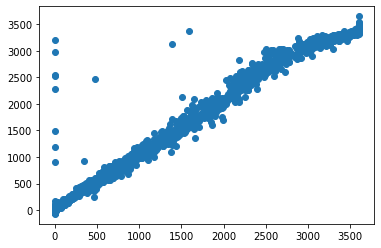

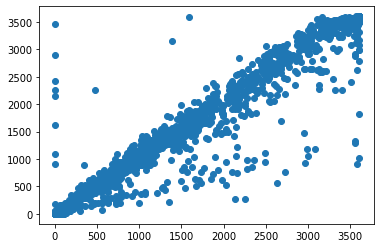

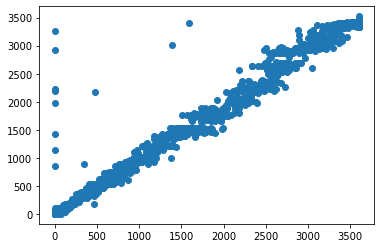

In [21]:
plt.scatter(y_test, preds_svr)
plt.show()
plt.scatter(y_test, preds_rf1)
plt.show()
#plt.scatter(y_test, preds_xgb1)
#plt.show()
plt.scatter(y_test, preds_rf2)
plt.show()
#plt.scatter(y_test, preds_xgb2)
#plt.show()

In [22]:
df1=pd.DataFrame(y_test)
df2=pd.DataFrame(preds_rf2)
df1.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)
df_pred=pd.concat([df1, df2],axis=1).rename(columns= {0:'Predictions'})

df_pred.head()

,Power,Predictions
0,2041.109985,1880.585154
1,1439.529053,1201.164968
2,1211.551025,1100.185035
3,1087.824951,968.777877
4,1201.161011,1201.291773


In [23]:
df_pred['abs_pred']=np.absolute(df_pred.Power-df_pred.Predictions)
predictions = df_pred.loc[df_pred['abs_pred'] <200,:]
print(predictions)

            Power  Predictions    abs_pred
0     2041.109985  1880.585154  160.524831
2     1211.551025  1100.185035  111.365990
3     1087.824951   968.777877  119.047074
4     1201.161011  1201.291773    0.130762
5     1576.302002  1431.766286  144.535716
...           ...          ...         ...
1678  1776.979004  1700.244041   76.734962
1679  2490.826904  2320.495520  170.331385
1681  1534.213013  1389.442511  144.770502
1682  1515.897949  1383.655351  132.242598
1684  1443.677979  1370.726760   72.951218

[1518 rows x 3 columns]


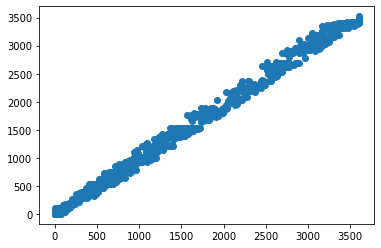

In [24]:
plt.scatter(predictions.Power, predictions.Predictions)
plt.show()

In [26]:
# The best model seems to be the random forest regression model with randomized search 
#import seaborn as sns
#sns.distplot(predictions.Power, predictions.Predictions)



In [27]:
# Store the model
import pickle
file = open('Wind_Power_Prediction_Model.pkl', 'wb')
pickle.dump(rf_random, file)